In [25]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint, uniform

# Load data
df = pd.read_csv("../data/raw/full_data.csv")

# Define features and target
features = ["porosity", "T", "strainrate", "strain"]
target = "stress"
X = df[features]
y = df[target]

In [27]:
# Split data 
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define hyperparameter search space
param_dist = {
    "num_leaves": randint(16, 128),
    "max_depth": randint(5, 65),
    "min_data_in_leaf": randint(20, 50),
    "learning_rate": uniform(0.01, 0.4),
    "feature_fraction": uniform(0.7, 0.3),
    "bagging_fraction": uniform(0.7, 0.3),
    "bagging_freq": randint(1, 5),
    "lambda_l1": uniform(0.0, 5.0),
    "lambda_l2": uniform(0.0, 5.0),
    "n_estimators": randint(50, 200)
}

# Fixed LGBM parameters
fixed_params = {
    "objective": "regression",
    "metric": "mae",
    "boosting_type": "gbdt",
    "verbose": -1,
    "n_jobs": -1
}

# Create model
model = lgb.LGBMRegressor(**fixed_params)

# Run RandomizedSearchCV with 5-fold CV
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,  
    scoring="neg_mean_absolute_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search to training data
search.fit(X_train, y_train)

# Evaluate on validation set
best_model = search.best_estimator_
y_pred = best_model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)

best_params_rounded = {
    k: round(v, 2) if isinstance(v, float) else v
    for k, v in search.best_params_.items()
}

final_model = lgb.LGBMRegressor(**search.best_params_)
final_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

# Save model and results
os.makedirs("../models/lightgbm_model", exist_ok=True)
joblib.dump(final_model, "../models/lightgbm_model/lgb_model.pkl")

# Save MAE and best parameters to CSV 
result_df = pd.DataFrame([{
    "mae": round(mae, 2),
    **best_params_rounded
}])
result_df.to_csv("../models/lightgbm_model/lgb_mae_params.csv", index=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [28]:
def predict_stress_curve_lgb(porosity, T, rate, strain_step=0.001,
                             model_path="../models/lightgbm_model/lgb_model.pkl"):
    model = joblib.load(model_path)
    strain_range = np.arange(0, 0.25, strain_step)
    
    test_df = pd.DataFrame({
        "porosity": porosity,
        "T": T,
        "strainrate": rate,
        "strain": strain_range
    })
    
    stress_pred = model.predict(test_df)
    return strain_range, stress_pred

In [29]:
def plot_lgb_curve(porosity, T, rate, strain_step=0.001):
    strains, stress = predict_stress_curve_lgb(porosity, T, rate, strain_step)
    plt.figure(figsize=(6, 4))
    plt.plot(strains, stress, label=f"porosity={porosity}, T={T}, rate={rate}")
    plt.xlabel("Strain")
    plt.ylabel("Stress (MPa)")
    plt.title("Stress-Strain Curve (LightGBM)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

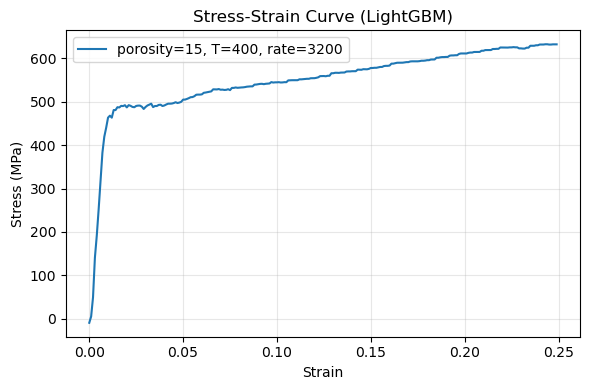

In [30]:
plot_lgb_curve(porosity=15, T=400, rate=3200)